In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
import zipfile
import io

In [0]:
zf = zipfile.ZipFile(io.BytesIO(uploaded['4 ML ranking (2).zip']), "r")
zf.extractall()

In [0]:
# LOAD TRAIN DATA
file_learning = './4 ML ranking/imat2009-datasets/imat2009_learning.txt'

with open(file_learning) as f:
    train_data = f.readlines()
    
    
# LOAD TEST DATA
file_test = './4 ML ranking/imat2009-datasets/imat2009_test.txt'

with open(file_test) as f:
    test_data = f.readlines()

In [0]:
len(train_data), len(test_data)

(97290, 115643)

In [0]:
import numpy as np
from collections import defaultdict

In [0]:
labels = [] 
queries_lines_info = defaultdict(list) 

train_data = train_data[:100]
data = np.zeros((len(train_data), 245), dtype=np.float32) 


for i, line in enumerate(train_data):
    line_data = line.split(' ')
    
    label = float(line_data[0])
    query_id = int(line_data[-1])
    
    labels.append(label)
    queries_lines_info[query_id].append(i)
    
    for feat_data in line_data[1:-2]:
        feat_id, feat_value = feat_data.split(':')
        feat_id = int(feat_id)-1
        
        data[i, feat_id] = feat_value

In [0]:
#check
assert data.shape == (len(train_data), 245)
assert len(queries_lines_info.keys()) == 9124
assert len(labels) == len(train_data)

AssertionError: ignored

In [0]:
from sklearn.model_selection import train_test_split

queries_ids = list(queries_lines_info.keys())
train_queries_ids, test_queries_ids = train_test_split(queries_ids, test_size=0.33, random_state=42)

In [0]:
# check
assert len(train_queries_ids) / (len(train_queries_ids) + len(test_queries_ids)) == 0.6999123191582639

AssertionError: ignored

In [0]:
train_queries_lines_info = []
test_queries_lines_info = []

for query_id in train_queries_ids:
    train_queries_lines_info += queries_lines_info[query_id]
    
for query_id in test_queries_ids:
    test_queries_lines_info += queries_lines_info[query_id]

labels = np.array(labels)

X_train, y_train = data[train_queries_lines_info], labels[train_queries_lines_info]
X_test, y_test = data[test_queries_lines_info], labels[test_queries_lines_info]

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('metrics.py','wb').write(src)
import metrics

Saving metrics.py to metrics (1).py


In [0]:
import metrics

In [0]:
def get_nDCG_score(queries, queries_lines_info, test_queries_lines_info, labels_true, labels_predicted):
    nDCG_scores = []
    
    for query in queries:
        
        query_lines = queries_lines_info[query]
        query_lines_in_testdata = [np.where(test_queries_lines_info==line)[0][0] for line in query_lines]
        
        query_labels_true = labels[query_lines]
        query_labels_pred = labels_predicted[query_lines_in_testdata]
        nDCG = metrics.ndcg_score(query_labels_true, query_labels_pred, k=10)
        nDCG_scores.append(nDCG)
        
    nDCG_Queries = np.sum(nDCG_scores) / len(queries) 
    return nDCG_Queries

# FIT PREDICT

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_y_pred = lin_reg.predict(X_test)

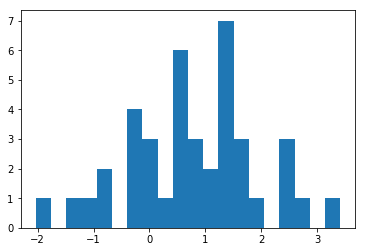

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

h = plt.hist(lin_reg_y_pred, bins=20)

In [59]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lin_reg_y_pred
  )
 
score_lin_reg

AttributeError: ignored

# LinearSVC

In [0]:
from sklearn.svm import LinearSVC

In [0]:
from sklearn import preprocessing
from sklearn import utils

In [0]:
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(y_train)

In [0]:
svc = LinearSVC()
svc.fit(X_train, encoded)
svc_y_pred = svc.predict(X_test)

In [40]:
print(svc_y_pred)

[2 6 2 2 6 2 4 6 2 0 6 0 0 0 0 0 4 0 0 0 0 0 0 0 0 4 2 4 2 4 0 0 2 2 4 4 2
 2 2 2]


In [49]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = svc_y_pred
)

score_svc

IndexError: ignored

# RandomForestRegressor

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
rfr = RandomForestRegressor()

In [44]:
rfr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
pred = rfr.predict(X_test)

In [50]:
pred

array([1.7 , 0.55, 1.45, 1.15, 1.45, 0.9 , 1.3 , 0.8 , 0.85, 0.75, 1.55,
       1.8 , 0.8 , 0.95, 0.95, 0.4 , 1.45, 0.95, 1.2 , 0.9 , 0.55, 0.85,
       1.  , 0.55, 1.5 , 0.55, 0.7 , 0.7 , 1.3 , 0.7 , 0.8 , 0.9 , 1.5 ,
       1.5 , 0.95, 1.35, 1.9 , 1.2 , 1.2 , 1.85])

In [48]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = pred
)

score_rfr

IndexError: ignored

# XGBoost

In [0]:
import xgboost as xgb

In [0]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [53]:
xg_reg.fit(X_train,y_train)

[00:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
preds = xg_reg.predict(X_test)

In [61]:
preds

array([0.3112563 , 0.7489768 , 0.44168884, 0.3607046 , 0.33960858,
       0.6618662 , 0.65547234, 0.43741474, 0.8624145 , 0.47855395,
       0.31928194, 0.9163122 , 0.42835033, 0.6101295 , 0.3443718 ,
       0.3160652 , 1.0747392 , 0.5298595 , 0.8989055 , 0.9052383 ,
       0.38727188, 0.49472326, 0.83834076, 0.373645  , 0.68520343,
       0.93249834, 0.46410012, 0.89152455, 0.52982986, 0.36554652,
       0.4567876 , 0.4461905 , 0.9064301 , 1.0285332 , 0.95790374,
       1.2008677 , 0.9757049 , 0.7449675 , 0.8158777 , 0.9980595 ],
      dtype=float32)

# LightGBM

In [0]:
import lightgbm as lgb

In [0]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [0]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

In [0]:
num_round = 10

In [67]:
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's auc: 0.493333
[2]	valid_0's auc: 0.516
[3]	valid_0's auc: 0.481333
[4]	valid_0's auc: 0.486667
[5]	valid_0's auc: 0.426667
[6]	valid_0's auc: 0.450667
[7]	valid_0's auc: 0.424
[8]	valid_0's auc: 0.426667
[9]	valid_0's auc: 0.442667
[10]	valid_0's auc: 0.430667


In [0]:
pred = bst.predict(X_test)

In [69]:
pred

array([0.57817326, 0.54830287, 0.66709021, 0.66709021, 0.62097495,
       0.82882247, 0.77197562, 0.59199661, 0.58598417, 0.77182462,
       0.58597747, 0.54829602, 0.52242626, 0.81467923, 0.82478685,
       0.78621662, 0.85857865, 0.79494613, 0.85857865, 0.74629437,
       0.75639459, 0.48013786, 0.56053606, 0.7498922 , 0.78621662,
       0.57433698, 0.58597747, 0.57816652, 0.63215689, 0.54829602,
       0.63215689, 0.63215689, 0.81640454, 0.82478685, 0.84778808,
       0.79787621, 0.83831554, 0.78966245, 0.81640454, 0.85463479])

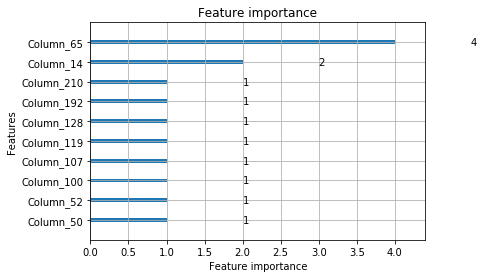

In [70]:
ax = lgb.plot_importance(bst, max_num_features=10)
plt.show()